<a href="https://colab.research.google.com/github/Elieser1945/DeepLearning/blob/main/Tugas_Week_3_CNN_dan_MLP_(TensorFlow)_CIFAR_10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌Model Deep Learning CNN dan MLP (PyTorch dan TensorFlow)

# CNN dan MLP (TensorFlow) CIFAR-10 Dataset

# Import library

In [16]:
import tensorflow as tf # Library utama untuk deep learning
import tensorflow_datasets as tfds # Library untuk dataset
import numpy as np # Library untuk manipulasi array
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix # Library untuk metrik evaluasi
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization # Library untuk layer-layer CNN
from tensorflow.keras.models import Sequential # Library untuk model sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Library untuk callbacks
from tensorflow.keras.optimizers import Adam # Library untuk optimizers

# Memuat Dataset CIFAR-10 dan Augmentasi

In [17]:
# Memuat dataset CIFAR-10
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10', # Dataset CIFAR-10
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Fungsi preprocessing
def normalize_img(image, label):
    """Normalisasi gambar: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Mengatur alur data untuk training
BATCH_SIZE = 64
ds_train = ds_train.map(normalize_img)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# Mengatur alur data untuk testing
ds_test = ds_test.map(normalize_img)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

# Menyusun Model

In [3]:
def create_mlp_model():
    model = Sequential([
        # Flattening input gambar 32x32x3 menjadi 3072 fitur
        Flatten(input_shape=(32, 32, 3)),

        # Layer hidden 1
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Layer hidden 2
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Layer hidden 3
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Layer hidden 4
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        # Layer output
        Dense(10, activation='softmax')  # 10 kelas untuk CIFAR-10
    ])

    return model

# Inisialisasi model
mlp_model = create_mlp_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Latih Model

In [5]:
# Callbacks untuk training
# Menghentikan pelatihan lebih awal jika tidak ada peningkatan dalam 15 epoch
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Melatih model
history = mlp_model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_test,
    callbacks=callbacks
)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.2396 - loss: 2.2990 - val_accuracy: 0.3372 - val_loss: 1.8222 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3490 - loss: 1.8062 - val_accuracy: 0.3975 - val_loss: 1.6848 - learning_rate: 0.0010
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3852 - loss: 1.7189 - val_accuracy: 0.3992 - val_loss: 1.6565 - learning_rate: 0.0010
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3901 - loss: 1.6982 - val_accuracy: 0.4174 - val_loss: 1.6345 - learning_rate: 0.0010
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4044 - loss: 1.6712 - val_accuracy: 0.4173 - val_loss: 1.6162 - learning_rate: 0.0010
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4101 - loss: 1.6470 - val_accuracy: 0.4280 - val_loss: 1.5848 - learning_rate: 0.0010
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4023 - loss: 

# Evaluasi Model (Akurasi, Presisi, Recall, F1 Squared, AUC dan ROC)

In [7]:
def evaluate_metrics(y_true, y_pred, y_prob):
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=10)

    # Menghitung metrik evaluasi
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true_one_hot, y_prob, average='macro', multi_class='ovr')

    return precision, recall, f1, roc_auc

In [8]:
# Evaluasi model
test_loss, test_accuracy = mlp_model.evaluate(ds_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Konversi dataset untuk evaluasi metrik lengkap
y_true = []
y_pred = []
y_pred_proba = []

for images, labels in ds_test:
    predictions = mlp_model.predict(images)
    y_pred_proba.extend(predictions)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Menghitung metrik evaluasi
precision, recall, f1, roc_auc = evaluate_metrics(y_true, y_pred, y_pred_proba)

# Output metrik evaluasi
print("\nMetrik Evaluasi MLP Model dengan TensorFlow:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5266 - loss: 1.3371
Test accuracy: 0.5208
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

# visualisasi

In [14]:
def visualize_results(history):
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.matshow(cm, cmap='Blues')
    plt.colorbar()
    plt.title('Confusion Matrix')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j] / cm.sum() * 100:.1f}%', ha='center', va='bottom', color='lavender' if cm[i, j] > cm.max() / 2 else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

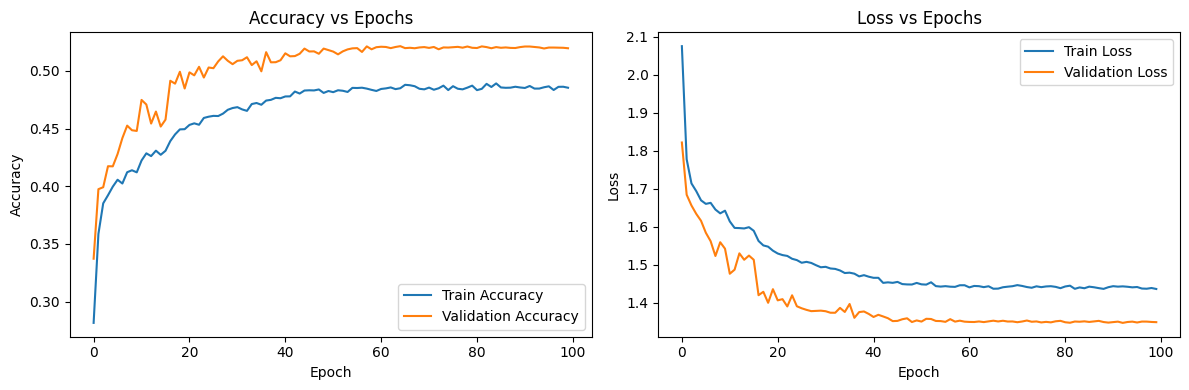

<Figure size 1000x800 with 0 Axes>

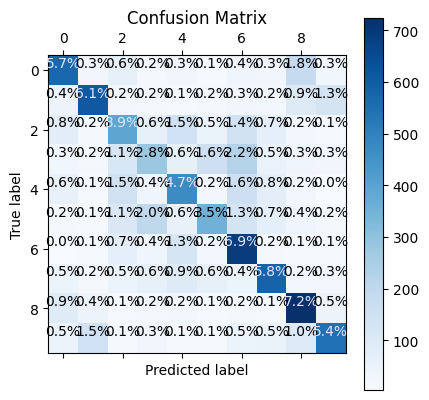

In [15]:
# Plot training history
visualize_results(history)

# Plot confusion matrix
visualize_confusion_matrix(y_true, y_pred)